# Disney Movie Wikipedia Web Scraping

## import packages

In [182]:
#Importing libraries for web scraping
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
sns.set()

%matplotlib inline


## Web Scraping & Data Cleaning

In [32]:
# Get list of all disney movies
r = requests.get("https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films")
soup = bs(r.content)
movies = soup.select(".wikitable.sortable i a")

In [33]:
#Getting Rid of Tags
def clean_tags(soup):
  for tag in soup.find_all(["sup", 'span']):
    tag.decompose()

In [34]:
# Scraping a single page function
def get_info_box(url):

  def get_content_value(row_data):
    if row_data.find("li"):
      return [li.get_text(" ", strip=True).replace("\xa0", ' ') for li in row_data.find_all('li')]
    elif row_data.find("br"):
      return [text for text in row_data.stripped_strings]
    else:
      return row_data.get_text(" ", strip=True).replace("\xa0", ' ')

  r = requests.get(url)
  soup = bs(r.content)
  info_box = soup.find(class_='infobox vevent')
  info_rows = info_box.find_all('tr')
  
  clean_tags(soup)

  movie_info={}

  for index, row in enumerate(info_rows):
    if index==0:
      movie_info['title']=row.find('th').get_text(" ",strip=True)
    elif index == 1:
      continue
    x = row.find('th')
    y = row.find('td')
    if x is not None and y is not None:
      key = row.find('th').get_text(" ",strip=True)
      value = get_content_value(row.find('td'))
      movie_info[key] = value

  return movie_info


In [ ]:
# Get list of  all movies info

base_path = "https://en.wikipedia.org"

movie_info_list = []

for index, movie in enumerate(movies):
  try:
    relative_path = movie['href']
    full_path = base_path + relative_path
    title = movie['title']
    movie_info_list.append(get_info_box(full_path))
  except Exception as e:
    print(movie.get_text())
    print(e)


In [36]:
len(movie_info_list)

449

## Data Cleaning

In [85]:
# Running time transfermation
def minute_transfer(running_time):
  if running_time == 'N/A':
    return None
  if isinstance(running_time,list):
    value = re.split("–| ", running_time[0])[0]
    return int(value)
  else:
    value = re.split("–| ", running_time)[0]
    return int(value)


In [86]:
# add minute key
for movie in movie_info_list:
  movie['Minute'] = minute_transfer(movie.get('Running time', 'N/A'))

In [91]:
# Money conversion (refer to Keith Galli's work)

amounts = r"thousand|million|billion"
number = r"\d+(,\d{3})*\.*\d*"

word_re = rf"\${number}(-|\sto\s|–)?({number})?\s({amounts})"
value_re = rf"\${number}"

def word_to_value(word):
    value_dict = {"thousand": 1000, "million": 1000000, "billion": 1000000000}
    return value_dict[word]

def parse_word_syntax(string):
    value_string = re.search(number, string).group()
    value = float(value_string.replace(",", ""))
    word = re.search(amounts, string, flags=re.I).group().lower()
    word_value = word_to_value(word)
    return value*word_value

def parse_value_syntax(string):
    value_string = re.search(number, string).group()
    value = float(value_string.replace(",", ""))
    return value

def money_conversion(money):
    if money == "N/A":
        return None

    if isinstance(money, list):
        money = money[0]
        
    word_syntax = re.search(word_re, money, flags=re.I)
    value_syntax = re.search(value_re, money)

    if word_syntax:
        return parse_word_syntax(word_syntax.group())

    elif value_syntax:
        return parse_value_syntax(value_syntax.group())

    else:
        return None

In [92]:
for movie in movie_info_list:
    movie['Budget value'] = money_conversion(movie.get('Budget', "N/A"))
    movie['Box office value'] = money_conversion(movie.get('Box office', "N/A"))

In [102]:
dates = [movie.get('Release date', 'N/A') for movie in movie_info_list]
def clean_date(date):
  return date.split('(')[0].strip()

def date_conversion(date):
  if isinstance(date, list):
    date = date[0]
  if date == 'N/A':
    return None
  date_str = clean_date(date)
  fmts = ["%B %d, %Y", "%d %B %Y", "%Y"]
  for fmt in fmts:
    try:
      return datetime.strptime(date_str, fmt)
    except:
      pass
      return None


In [103]:
for movie in movie_info_list:
    movie['Release date (datetime)'] = date_conversion(movie.get('Release date', 'N/A'))

## Convert to Pandas DataFrame

In [117]:
#Converting result into a DataFrame

df = pd.DataFrame(movie_info_list)

df.head()

,title,Production company,Release date,Running time,Country,Language,Box office,Minute,Budget value,Box office value,Release date (datetime),Directed by,Produced by,Written by,Based on,Starring,Music by,Distributed by,Budget,Story by,Narrated by,Cinematography,Edited by,Languages,Screenplay by,Countries,Production companies,Genre,Created by,Country of origin,No. of seasons,No. of episodes,Executive producers,Original network,Picture format,Audio format,Original release,Related shows,Japanese,Hepburn,Adaptation by,Animation by,Traditional,Simplified
0,Academy Award Review of,Walt Disney Productions,"[May 19, 1937]",41 minutes (74 minutes 1966 release),United States,English,$45.472,41.0,NaN,4.547200e+01,1937-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Snow White and the Seven Dwarfs,Walt Disney Productions,"[December 21, 1937 ( Carthay Circle Theatre , ...",83 minutes,United States,English,$418 million,83.0,1490000.0,4.180000e+08,1937-12-21,"[David Hand (supervising), William Cottrell, W...",Walt Disney,"[Ted Sears, Richard Creedon, Otto Englander, D...","[Snow White, by The, Brothers Grimm]","[Adriana Caselotti, Lucille La Verne, Harry St...","[Frank Churchill, Paul Smith, Leigh Harline]",RKO Radio Pictures,$1.49 million,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pinocchio,Walt Disney Productions,"[February 7, 1940 ( Center Theatre ), February...",88 minutes,United States,English,$164 million,88.0,2600000.0,1.640000e+08,1940-02-07,"[Ben Sharpsteen, Hamilton Luske, Bill Roberts,...",Walt Disney,NaN,"[The Adventures of Pinocchio, by, Carlo Collodi]","[Cliff Edwards, Dickie Jones, Christian Rub, W...","[Leigh Harline, Paul J. Smith]",RKO Radio Pictures,$2.6 million,"[Ted Sears, Otto Englander, Webb Smith, Willia...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fantasia,Walt Disney Productions,"[November 13, 1940]",126 minutes,United States,English,$76.4–$83.3 million,126.0,2280000.0,8.330000e+07,1940-11-13,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Walt Disney, Ben Sharpsteen]",NaN,NaN,"[Leopold Stokowski, Deems Taylor]",See program,RKO Radio Pictures,$2.28 million,"[Joe Grant, Dick Huemer]",Deems Taylor,James Wong Howe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The Reluctant Dragon,Walt Disney Productions,"[June 27, 1941]",74 minutes,United States,English,"$960,000 (worldwide rentals)",74.0,600000.0,9.600000e+05,1941-06-27,"[Alfred Werker, (live action), Hamilton Luske,...",Walt Disney,"[Live-action:, Ted Sears, Al Perkins, Larry Cl...",NaN,"[Robert Benchley, Frances Gifford, Buddy Peppe...","[Frank Churchill, Larry Morey]",RKO Radio Pictures,"$600,000",NaN,NaN,Bert Glennon,Paul Weatherwax,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
cols = ['title','Minute','Budget value','Box office value','Release date (datetime)']
df_cols = df.loc[:,cols]
df_cols['Year'] = pd.DatetimeIndex(df_cols['Release date (datetime)']).year
df_cols.head()

,title,Minute,Budget value,Box office value,Release date (datetime),Year
0,Academy Award Review of,41.0,NaN,4.547200e+01,1937-05-19,1937.0
1,Snow White and the Seven Dwarfs,83.0,1490000.0,4.180000e+08,1937-12-21,1937.0
2,Pinocchio,88.0,2600000.0,1.640000e+08,1940-02-07,1940.0
3,Fantasia,126.0,2280000.0,8.330000e+07,1940-11-13,1940.0
4,The Reluctant Dragon,74.0,600000.0,9.600000e+05,1941-06-27,1941.0


##Plot the number of disney movies by decade. 

In [119]:
# convert to decade
def decade(year):
  return year - year%10
df_cols['Decade Year'] = df_cols['Year'].apply(decade)
df_cols.head()

,title,Minute,Budget value,Box office value,Release date (datetime),Year,Decade Year
0,Academy Award Review of,41.0,NaN,4.547200e+01,1937-05-19,1937.0,1930.0
1,Snow White and the Seven Dwarfs,83.0,1490000.0,4.180000e+08,1937-12-21,1937.0,1930.0
2,Pinocchio,88.0,2600000.0,1.640000e+08,1940-02-07,1940.0,1940.0
3,Fantasia,126.0,2280000.0,8.330000e+07,1940-11-13,1940.0,1940.0
4,The Reluctant Dragon,74.0,600000.0,9.600000e+05,1941-06-27,1941.0,1940.0


In [120]:
df_decade = df_cols.groupby('Decade Year').count()

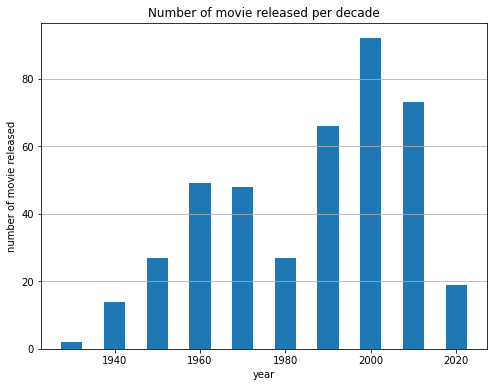

In [128]:
x = df_decade.index
y = df_decade["title"]

plt.figure(figsize=(8, 6))
plt.bar(x,y,width=5)
plt.title("Number of movie released per decade")
plt.xlabel("year")
plt.ylabel("number of movie released")
plt.grid(axis='y')

plt.show()

##Output the 10 movies that had the highest Budget.

In [130]:
Budget = df_cols.sort_values(by='Budget value',ascending=False)
highest = list(Budget['title'][0:10])
highest

['Pirates of the Caribbean: On Stranger Tides',
 'John Carter',
 "Pirates of the Caribbean: At World's End",
 'Tangled',
 'The Lion King',
 'Pirates of the Caribbean: Dead Men Tell No Tales',
 'The Lone Ranger',
 'The Chronicles of Narnia: Prince Caspian',
 "Pirates of the Caribbean: Dead Man's Chest",
 'Oz the Great and Powerful']

Pirates of the Caribbean series holds four places in Top 10 Budget movies.

## Improvement


### Correlation test

In [168]:
df_net = df_cols.set_index('title')
df_net = df_net.dropna()
df_net['net income'] = df_net['Box office value'] - df_net['Budget value']

In [143]:
features = ['Minute','Year']
df_net_features = df_net.loc[:,features]
df_net_target = df_net['net income']

In [145]:
sm.OLS(df_net_target, df_net_features).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             net income   R-squared (uncentered):                   0.322
Model:                            OLS   Adj. R-squared (uncentered):              0.317
Method:                 Least Squares   F-statistic:                              60.19
Date:                Wed, 28 Apr 2021   Prob (F-statistic):                    4.15e-22
Time:                        13:46:12   Log-Likelihood:                         -5290.9
No. Observations:                 255   AIC:                                  1.059e+04
Df Residuals:                     253   BIC:                                  1.059e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Minute      2.732e+06   8.32e+05      3.284      0.001    1.09e+06    4.37e+06
Year       -5.412e+04   4.21e+04     -1.285      0.200   -1.37e+05    2.88e+04
==============================================================================
Omnibus:                      126.888   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.952
Skew:                           2.156   Prob(JB):                    1.49e-107
Kurtosis:                       8.264   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With pvalue=0.001,we can reject the null hypothesis for 'Minute' with 99% level of confidance. While 'Year' didn't pass the test.

### Linear regression of Minute vs. Net Income

In [170]:
# transform net income in million unit
df_net['net income(m)'] = df_net['net income']/1000000
df_net.head()

,Minute,Budget value,Box office value,Release date (datetime),Year,Decade Year,net income,net income(m)
title,,,,,,,,
Snow White and the Seven Dwarfs,83.0,1490000.0,418000000.0,1937-12-21,1937.0,1930.0,416510000.0,416.51
Pinocchio,88.0,2600000.0,164000000.0,1940-02-07,1940.0,1940.0,161400000.0,161.40
Fantasia,126.0,2280000.0,83300000.0,1940-11-13,1940.0,1940.0,81020000.0,81.02
The Reluctant Dragon,74.0,600000.0,960000.0,1941-06-27,1941.0,1940.0,360000.0,0.36
Dumbo,64.0,950000.0,1300000.0,1941-10-23,1941.0,1940.0,350000.0,0.35


In [186]:
x = df_net['Minute']
y = df_net['net income(m)']

x = sm.add_constant(x)

est = sm.OLS(y, x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          net income(m)   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     12.25
Date:                Wed, 28 Apr 2021   Prob (F-statistic):           0.000551
Time:                        15:02:55   Log-Likelihood:                -1767.6
No. Observations:                 255   AIC:                             3539.
Df Residuals:                     253   BIC:                             3546.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -122.8651     83.061     -1.479      0.140    -286.445      40.714
Minute         2.8753      0.822      3.499      0.001       1.257       4.494
==============================================================================
Omnibus:                      125.921   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.304
Skew:                           2.140   Prob(JB):                    6.83e-106
Kurtosis:                       8.222   Cond. No.                         539.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

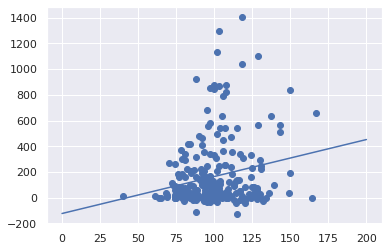

In [190]:
xfit = np.linspace(0, 200, 10000)
yfit = est.predict(sm.add_constant(xfit))

plt.scatter(df_net['Minute'], df_net['net income(m)'])
plt.plot(xfit, yfit)

In [191]:
est2 = sm.OLS(y, x).fit(cov_type='HC2')
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          net income(m)   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     12.56
Date:                Wed, 28 Apr 2021   Prob (F-statistic):           0.000468
Time:                        15:05:30   Log-Likelihood:                -1767.6
No. Observations:                 255   AIC:                             3539.
Df Residuals:                     253   BIC:                             3546.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -122.8651     74.202     -1.656      0.098    -268.298      22.567
Minute         2.8753      0.811      3.544      0.000       1.285       4.465
==============================================================================
Omnibus:                      125.921   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.304
Skew:                           2.140   Prob(JB):                    6.83e-106
Kurtosis:                       8.222   Cond. No.                         539.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""